In [2]:
import numpy as np
import matplotlib.pyplot as plt

True classes are dog and cat, and weak classes are proportion of black, white and brown.

$$P(\tilde{Y}=\tilde{C}_j|X=\mathbf{x}) = \sum_{i = 1}^K P(\tilde{Y}=\tilde{C}_j|Y=C_i, X=\mathbf{x}) P(Y=C_i|X=\mathbf{x}).$$


In [61]:
true_classes = ['dog', 'cat']
weak_classes = ['black', 'white', 'brown']

M = np.array([[0.3, 0.1, 0.6], [0.7, 0.2, 0.1]]).T
print(M)
np.testing.assert_array_almost_equal(np.inner(M.T, np.ones(M.shape[0])), np.ones(M.shape[1]))

[[0.3 0.7]
 [0.1 0.2]
 [0.6 0.1]]


We can now convert any probability in the true space, to a probability in the weak space with an inner product

$$\mathbf{\widetilde{q}}(\mathbf{x}) = M(\mathbf{x}) \mathbf{q}(\mathbf{x})$$

[0.46 0.14 0.4 ]


Text(0, 0.5, '$P(\\widetilde{Y}=\\widetilde{c}|X=x)$')

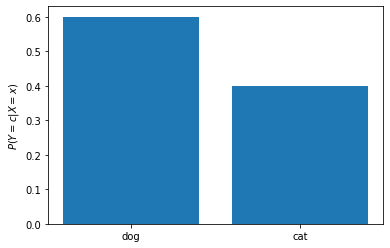

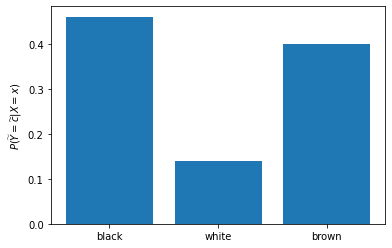

In [73]:
p = np.array([0.6, 0.4])

q = np.inner(M, p)
print(q)

plt.bar(np.arange(p.shape[0]), p)
plt.xticks(np.arange(p.shape[0]), true_classes)
plt.ylabel('$P(Y=c|X=x)$')

plt.figure()
plt.bar(np.arange(q.shape[0]), q)
plt.xticks(np.arange(q.shape[0]), weak_classes)
plt.ylabel('$P(\widetilde{Y}=\widetilde{c}|X=x)$')

$$\mathbf{q}(\mathbf{x}) = M^{+} \mathbf{\widetilde{q}}(\mathbf{x})$$

[0.6 0.4]


Text(0, 0.5, '$P(Y=c|X=x)$')

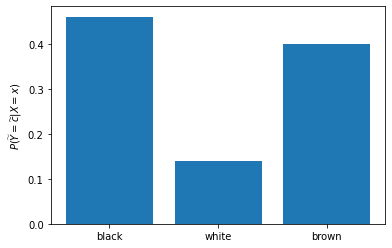

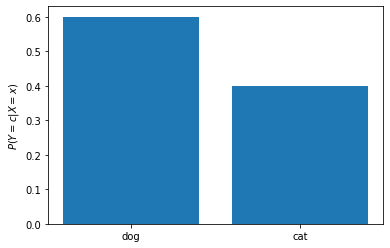

In [75]:
M_inv = np.linalg.pinv(M)

p = np.inner(M_inv, q)
print(p)

plt.bar(np.arange(q.shape[0]), q)
plt.xticks(np.arange(q.shape[0]), weak_classes)
plt.ylabel('$P(\widetilde{Y}=\widetilde{c}|X=x)$')

plt.figure()
plt.bar(np.arange(p.shape[0]), p)
plt.xticks(np.arange(p.shape[0]), true_classes)
plt.ylabel('$P(Y=c|X=x)$')

With the mixing matrix $M$ and its inverse we can construct losses 

$$\tilde{\Psi}(q(x)) = M^{+\intercal} \Psi(q(x))$$

In [190]:
def brier(y, q):
    return np.sum((y - q)**2, axis=1)

def loss_vector(q, loss):
    nb_classes = q.shape[1]
    p = np.eye(nb_classes)[np.arange(nb_classes)]
    result = np.zeros([q.shape[0], nb_classes])
    for i, q_i in enumerate(q):
        result[i] = loss(p, q_i)
    return result

def brier_vector(q):
    return loss_vector(q, brier)

q = np.array([[1.0, 0.0], 
              [0.7, 0.3],
              [0.5, 0.5],
              [0.0, 1.0]]).reshape(-1, 2)
print('Predicted probabilities')
print(q)

l = brier_vector(q)
print('Loss in vector form')
print(l)

Predicted probabilities
[[1.  0. ]
 [0.7 0.3]
 [0.5 0.5]
 [0.  1. ]]
Loss in vector form
[[0.   2.  ]
 [0.18 0.98]
 [0.5  0.5 ]
 [2.   0.  ]]


Notice that given the vector form of the loss, it is possible to use the true label as an index to select the corresponding loss of a sample. This can be done in a vector multiplication form as

$$\Psi(\mathbf{y}, \mathbf{q}) = (\mathbf{y}^\intercal M^\intercal) \Psi(\mathbf{q})$$

In [191]:
def loss_weighted(weight, q, loss_v):
    return np.sum(weight * loss_v(q), axis=1)

p = np.tile(np.array([[1, 0]]), q.shape[0]).reshape(q.shape[0], -1)
print('True probabilities')
print(p)

print('losses')
loss_weighted(p, q, brier_vector)

True probabilities
[[1 0]
 [1 0]
 [1 0]
 [1 0]]
losses


array([0.  , 0.18, 0.5 , 2.  ])

$$\tilde{\Psi}(\mathbf{\tilde{y}}, \mathbf{q}) = \mathbf{\tilde{y}}^\intercal M^{+\intercal} \Psi(\mathbf{q})$$

In [187]:
def weak_loss_vector(z, q, M, loss_v):
    M_inv = np.linalg.pinv(M)
    return loss_weighted(np.squeeze(M_inv[:,z].T), q, loss_v)

z = np.array([[0, 1, 2, 0]]).T

weak_loss_vector(z, q, M, brier_vector)

array([ 2.86062082,  0.37139379,  0.50821668, -0.49908704])

In [69]:
p = np.array([0.6, 0.4])

def brier(p, q):
    return np.sum((p - q)**2, axis=1)

loss = brier

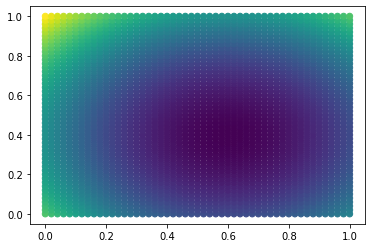

In [38]:
x = y = np.linspace(0, 1, 51)
xx, yy = np.meshgrid(x, y)
points = np.vstack([xx.ravel(), yy.ravel()]).T
plt.scatter(points[:,0], points[:,1], c=loss(p, points), cmap='viridis')

In [39]:
M = np.array([[1, 2], [0, 2]]).T
print(M)

[[1 0]
 [2 2]]


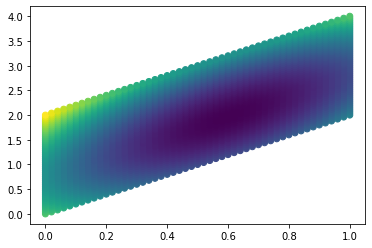

In [42]:
def weak_loss(p, q, loss, M):
    M_inv = np.linalg.pinv(M)
    return loss(p, np.inner(q, M_inv))

#def weak_loss(p, q, loss, M):
#    M_inv = np.linalg.pinv(M)
#    return loss(np.inner(p, M_inv), q)

points_transformed = np.inner(points, M)
plt.scatter(points_transformed[:,0], points_transformed[:,1],
            c=weak_loss(p, points_transformed, loss, M), cmap='viridis')

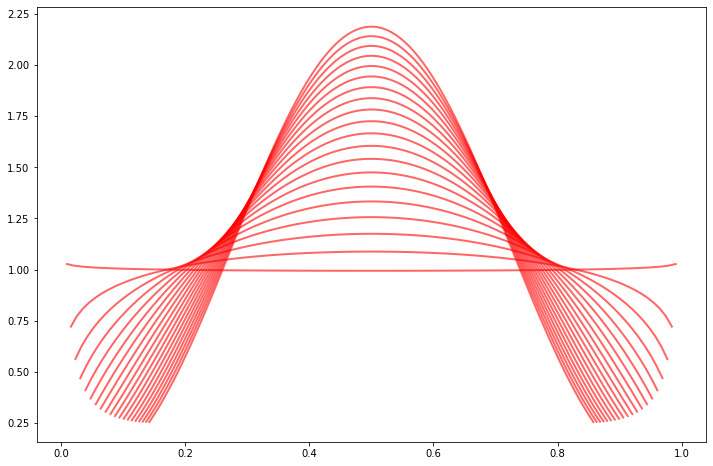

In [210]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for a in np.linspace(0.99, 4, 20):
    b = a
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
    x = np.linspace(beta.ppf(0.01, a, b),
                    beta.ppf(0.99, a, b), 100)
    ax.plot(x, beta.pdf(x, a, b),
           'r-', lw=2, alpha=0.6, label='beta pdf')